# Introduction

For my final capstone project at BrainStation, I decided to create a machine learning model that would predict the outcome of the 2019 NCAA March Madness Tournament. The data was sourced from the Kaggle competition: “Google Cloud & NCAA ML Competition 2019 – Men’s”. Using the average season statistics, seeding, tournament rating, and region of each game from 2008-2017 to train the model, the model is ultimately able to predict the probability of a team winning given any matchup they might encounter in the tournament. The end goal of this project is to accurately predict as many games correctly as possible, even potentially outperforming the brackets made by FiveThirtyEight and ESPN.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns',99)
import warnings 
warnings.filterwarnings('ignore')

# Import the files

The datasets provided on Kaggle are comprised of 19 csv files with general information about the tournament, and 18 csv files with play-by-play information for games played from 2010-2017. Due to the complexities and computation time required to process several gigabytes worth of play-by-play data, I chose to utilize the core datasets to build my model.

In the code below, I organized the datasets into 4 categories. "Basics" represents the barebones datasets needed to build a machine learning model. "BoxScores" are for the details needed to add complexity to the model. "Rankings" were an additional factor I wanted to add to the model to test for predictive power. "Supplements" includes additional qualitative information that I might want to leverage for exploratory analysis.

To increase code efficiency, I opted to use a for loop to load all 10 files at once, with a section subsequently dedicated to instantiating the datasets with unique names.

In [2]:
Basics = ['Teams.csv','Seasons.csv','NCAATourneySeeds.csv',
          'RegularSeasonCompactResults.csv','NCAATourneyCompactResults.csv']

BoxScores = ['RegularSeasonDetailedResults.csv','NCAATourneyDetailedResults.csv']

Rankings = ['MasseyOrdinals.csv']

Supplements = ['Conferences.csv','TeamConferences.csv']

Data = [Basics,BoxScores,Rankings,Supplements]

FileIn = []

for lists in Data:
    for csv in lists:
        print(f'File: {csv}, {lists.index(csv)}')
        Df = pd.read_csv(f'DataFiles/{csv}')
        FileIn.append(Df)

#Basics
Teams = FileIn[0]
Seasons = FileIn[1]
NCAASeeds = FileIn[2]
RSCompact = FileIn[3]
NCAACompact = FileIn[4]

#Box Scores
RSDetailed = FileIn[5]
NCAADetailed = FileIn[6]

#Rankings
MasseyRank = FileIn[7]

#Supplementary
Conferences = FileIn[8]
TeamConferences = FileIn[9]

File: Teams.csv, 0
File: Seasons.csv, 1
File: NCAATourneySeeds.csv, 2
File: RegularSeasonCompactResults.csv, 3
File: NCAATourneyCompactResults.csv, 4
File: RegularSeasonDetailedResults.csv, 0
File: NCAATourneyDetailedResults.csv, 1
File: MasseyOrdinals.csv, 0
File: Conferences.csv, 0
File: TeamConferences.csv, 1


# Data Cleaning

To begin cleaning, I first combined the compact statistics datasets for regular season and NCAA. I did this to view season and tournament data in one place to gain a wholistic view of the data. Once the combined dataset was created, I created two new columns: 'WPointDiff' and 'LPointDiff'. The data is formatted where Winning teams and losing teams have their own columns, I felt that having separate columns for Winner and Loser point differential would be important for future analysis. I chose point differential to calculate the margin that each team wins and loses by; this will be important when we average the season data per team.

It is important to note that each individual row in the dataset represents the outcome of one game played in that season.

In [3]:
RSCompact['Tournament'] = 'Regular Season'
NCAACompact['Tournament'] = 'NCAA Tournament'

CompactStats = pd.concat([RSCompact,NCAACompact],axis=0)
CompactStats['WPointDiff'] = CompactStats['WScore'] - CompactStats['LScore']
CompactStats['LPointDiff'] = -CompactStats['WPointDiff']

In [15]:
CompactStats.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Tournament,WPointDiff,LPointDiff
0,1985,20,1228,81,1328,64,N,0,Regular Season,17,-17
1,1985,25,1106,77,1354,70,H,0,Regular Season,7,-7
2,1985,25,1112,63,1223,56,H,0,Regular Season,7,-7
3,1985,25,1165,70,1432,54,H,0,Regular Season,16,-16
4,1985,25,1192,86,1447,74,H,0,Regular Season,12,-12


After the initial step, I began combining the other datasets with my new CompactStats dataset, starting with the seeds of each team. I did not think that adding the team's week by week ranking was important; I only cared for the team's end of season ranking heading into the tournament as I felt that this was the best indicator of the team's seed for that season. The NCAASeeds dataset was merged twice with the CompactStats dataset (instantiated as "Model") to account for the seeds of the winning and losing team. The same process was applied to the TeamNames and Region datasets.

For region data, I chose to fill all the null values with a 'DNC' (did not compete). I wanted to keep them in the dataset because I wanted the model to recognize a tournament team's performance against non-competing teams, potentially identifying any problem areas that may have occured from those matchups.

Adding the RSDetailed and NCAADetailed datasets was important for adding more complexity to the model. These datasets contained more granular statistics of each game, providing more insight outside of just the end-score. I created a "Tournament" column to help better identify games that took place in the regular season versus the NCAA tournament. I then rearranged the dataset with a for loop to have the regional data and tournament signifier at the end of the new Model_Detailed dataset.

Lastly, I added ranking data to the model. The Massey dataset had a teams day-to-day ranking throughout the regular season leading into the tournament. Similar to seeding, I chose to only look at the team's Massey rankings at the end of the regular season heading into the tournament. To do this, I identified that the last day of the season was on day 132.

In [4]:
# Add NCAA Seeds
Model = pd.merge(CompactStats,NCAASeeds,how='left',left_on=['WTeamID','Season'],right_on=['TeamID','Season'])
Model.drop(['TeamID'],axis = 1,inplace=True)
Model['WSeed'] = Model['Seed']
Model.drop(['Seed'],axis = 1, inplace = True)
Model.insert(3,'W_Seed',Model['WSeed'],allow_duplicates=False)
Model.drop(['WSeed'],axis=1,inplace = True)

Model = pd.merge(Model,NCAASeeds,how='left',left_on=['LTeamID','Season'],right_on=['TeamID','Season'])
Model.drop(['TeamID'],axis = 1,inplace=True)
Model['LSeed'] = Model['Seed']
Model.drop(['Seed'],axis = 1, inplace = True)
Model.insert(6,'L_Seed',Model['LSeed'],allow_duplicates=False)
Model.drop(['LSeed'],axis=1,inplace = True)

#Add TeamNames
Model2 = pd.merge(Model,Teams,how='left',left_on=['WTeamID'],right_on=['TeamID'])
Model2.drop(['TeamID','FirstD1Season','LastD1Season'],axis = 1,inplace=True)
Model2['WTeamName'] = Model2['TeamName']
Model2.insert(3,'W_TeamName',Model2['WTeamName'],allow_duplicates=False)
Model2.drop(['WTeamName','TeamName'],axis=1,inplace = True)

Model2 = pd.merge(Model2,Teams,how='left',left_on=['LTeamID'],right_on=['TeamID'])
Model2.drop(['TeamID','FirstD1Season','LastD1Season'],axis = 1,inplace=True)
Model2['LTeamName'] = Model2['TeamName']
Model2.insert(6,'L_TeamName',Model2['LTeamName'],allow_duplicates=False)
Model2.drop(['LTeamName','TeamName'],axis=1,inplace = True)

#Add Region Data
ModelDF = pd.merge(Model2,Seasons,how = 'left',on = 'Season')
ModelDF['W_Seed'] = ModelDF['W_Seed'].fillna(value='DNC')
ModelDF['L_Seed'] = ModelDF['L_Seed'].fillna(value='DNC')

#Add Detailed season data and reorganize the columns
RSDetailed['Tournament'] = 'Regular Season'
NCAADetailed['Tournament'] = 'NCAA Tournament'
DetailedStats = pd.concat([RSDetailed,NCAADetailed],axis=0)
ModelDetailed = pd.merge(ModelDF,DetailedStats, how = 'inner')
Model_Detailed = ModelDetailed[[col for col in ModelDetailed if col not in ['DayZero','RegionW','RegionX','RegionY','RegionZ','Tournament']] 
              + ['DayZero','RegionW','RegionX','RegionY','RegionZ','Tournament']]

#Add Massey Ranks
#Take ranking of the latest day and apply to rest of dataset
MasseyRank = MasseyRank[MasseyRank['RankingDayNum'] == 133]
MasseyRank.drop(['RankingDayNum'],axis=1, inplace=True)
#Separate the rankings into columns in order to choose best systems
MasseyRank = MasseyRank.pivot_table('OrdinalRank', ['Season', 'TeamID'], 'SystemName')
#Choose the best rankings
Ratings = MasseyRank[['WOL','RTH','SAG','MOR']]

#Merge the model with ratings systems
ModelRanked = pd.merge(Model_Detailed,Ratings, how='left',left_on = ['WTeamID','Season']
                       ,right_on=['TeamID','Season'])

ModelRanked[['W_WOL','W_RTH','W_SAG','W_MOR']] = ModelRanked[['WOL','RTH','SAG','MOR']]
ModelRanked.drop(['WOL','RTH','SAG','MOR'],axis=1,inplace=True)
ModelRanked = pd.merge(ModelRanked,Ratings, how='left',left_on = ['LTeamID','Season']
                        ,right_on=['TeamID','Season'])
ModelRanked[['L_WOL','L_RTH','L_SAG','L_MOR']] = ModelRanked[['WOL','RTH','SAG','MOR']]
ModelRanked.drop(['WOL','RTH','SAG','MOR'],axis=1,inplace=True)

Massey rankings also posed an issue where there were an overabundance of ratings systems. Since some rankings systems were older than others, there were many systems full of null values. I ended up using four ratings systems: 'WOL','RTH','SAG','MOR'. These systems had little to no null values, and literature online had reaffirmed that these ratings had consistently provided accurate ratings for teams in the tournament. Lower numbers in the ranking indicate higher valued teams. I then added the ratings list to the model to create a model with rankings.

In [25]:
Ratings.head()

SystemName       WOL    RTH    SAG    MOR
Season TeamID                            
2003   1102    157.0  146.0  149.0  132.0
       1103    171.0  168.0  172.0  139.0
       1104     37.0   31.0   37.0   26.0
       1105    311.0  312.0  312.0  309.0
       1106    270.0  274.0  268.0  294.0

Once the ratings were added to create ModelRanked, I added each teams seed number to the dataset. Having the seed number separate would allow me to give numerical weight to each team even after one-hot encoding the regions. Here, I encountered a problem where there sometimes multiple teams sharing one seed within a region. This is due to the NCAA Tournament having a play-in tournament where closely ranked teams could compete in a pre-tournament to determine whether or not they could compete in March Madness. Since the NCAA dataset indicates the eventual winner of each play-in game (finalized seed with no a/b value), I reduced each a/b seed to be represented by the numerical value of 17, indicating that these teams were good enough to almost get into the tournament. Teams that did not compete in the tournament (had no a/b value or seeding) were given a seed number value of 18.

Conference data was then added to the Ranked dataset to provide more detail about each team.

In [5]:
numlist = ['01','02','03','04','05','06','07','08',
           '09','10','11','12','13','14','15','16']

for seed in numlist:
        ModelRanked.loc[ModelRanked.W_Seed == f'W{seed}','W_SeedNum'] = seed
        ModelRanked.loc[ModelRanked.W_Seed == f'X{seed}','W_SeedNum'] = seed
        ModelRanked.loc[ModelRanked.W_Seed == f'Y{seed}','W_SeedNum'] = seed
        ModelRanked.loc[ModelRanked.W_Seed == f'Z{seed}','W_SeedNum'] = seed
for seed in numlist:
        ModelRanked.loc[ModelRanked.L_Seed == f'W{seed}','L_SeedNum'] = seed
        ModelRanked.loc[ModelRanked.L_Seed == f'X{seed}','L_SeedNum'] = seed
        ModelRanked.loc[ModelRanked.L_Seed == f'Y{seed}','L_SeedNum'] = seed
        ModelRanked.loc[ModelRanked.L_Seed == f'Z{seed}','L_SeedNum'] = seed
        
#treat play-in teams as outside entities
#ultimately we only care about the finalized seeding for the tournament (no a's or b's)
playin_list = ['11a','11b','12a','12b','13a','13b','14a','14b','16a','16b']

for seed in playin_list:
        ModelRanked.loc[ModelRanked.W_Seed == f'W{seed}','W_SeedNum'] = 17
        ModelRanked.loc[ModelRanked.W_Seed == f'X{seed}','W_SeedNum'] = 17
        ModelRanked.loc[ModelRanked.W_Seed == f'Y{seed}','W_SeedNum'] = 17
        ModelRanked.loc[ModelRanked.W_Seed == f'Z{seed}','W_SeedNum'] = 17
        ModelRanked.loc[ModelRanked.L_Seed == f'W{seed}','L_SeedNum'] = 17
        ModelRanked.loc[ModelRanked.L_Seed == f'X{seed}','L_SeedNum'] = 17
        ModelRanked.loc[ModelRanked.L_Seed == f'Y{seed}','L_SeedNum'] = 17
        ModelRanked.loc[ModelRanked.L_Seed == f'Z{seed}','L_SeedNum'] = 17

ModelRanked['W_SeedNum'].fillna(value= 'DNC',inplace=True)
ModelRanked['L_SeedNum'].fillna(value= 'DNC',inplace=True)
ModelRanked['W_SeedNum'].replace(to_replace= 'DNC',value = 18, inplace=True)
ModelRanked['L_SeedNum'].replace(to_replace= 'DNC',value = 18, inplace=True)
ModelRanked['W_SeedNum'] = pd.to_numeric(ModelRanked['W_SeedNum'])
ModelRanked['L_SeedNum'] = pd.to_numeric(ModelRanked['L_SeedNum'])

#Create W_Region and L_Region column to enable one hot encoding
#we want to see the winner based on region
ModelRanked['W_Region'] = ModelRanked['W_Seed'].str.extract('(^[W-Z])',expand=True)
ModelRanked['L_Region'] = ModelRanked['L_Seed'].str.extract('(^[W-Z])',expand=True)
ModelRanked['W_Region'].fillna(value= 'DNC',inplace=True)
ModelRanked['L_Region'].fillna(value= 'DNC',inplace=True)

#Add Conferences
ConferenceDF = pd.merge(TeamConferences,Conferences)

ModelRankedv2 = pd.merge(ModelRanked,ConferenceDF,how='left',left_on=['WTeamID','Season'],right_on=['TeamID','Season'])
ModelRankedv2['W_Conf'] = ModelRankedv2['Description']
ModelRankedv2.drop(['TeamID','ConfAbbrev','Description'],axis=1,inplace=True)
ModelRankedv2 = pd.merge(ModelRankedv2,ConferenceDF,how='left',left_on=['LTeamID','Season'],right_on=['TeamID','Season'])
ModelRankedv2['L_Conf'] = ModelRankedv2['Description']
ModelRankedv2.drop(['TeamID','ConfAbbrev','Description'],axis=1,inplace=True)

In [21]:
ModelRanked.head()

,Season,DayNum,WTeamID,W_TeamName,W_Seed,WScore,L_TeamName,LTeamID,L_Seed,LScore,WLoc,NumOT,WPointDiff,LPointDiff,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,DayZero,RegionW,RegionX,RegionY,RegionZ,Tournament,W_WOL,W_RTH,W_SAG,W_MOR,L_WOL,L_RTH,L_SAG,L_MOR,W_SeedNum,L_SeedNum,W_Region,L_Region
0,2003,10,1104,Alabama,Y10,68,Oklahoma,1328,W01,62,N,0,6,-6,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,11/4/2002,East,South,Midwest,West,Regular Season,37.0,31.0,37.0,26.0,6.0,9.0,8.0,6.0,10,1,Y,W
1,2003,10,1272,Memphis,Z07,70,Syracuse,1393,W03,63,N,0,7,-7,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,11/4/2002,East,South,Midwest,West,Regular Season,19.0,19.0,24.0,23.0,5.0,12.0,12.0,21.0,7,3,Z,W
2,2003,11,1266,Marquette,Y03,73,Villanova,1437,DNC,61,N,0,12,-12,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,11/4/2002,East,South,Midwest,West,Regular Season,8.0,13.0,14.0,18.0,81.0,62.0,62.0,61.0,3,18,Y,DNC
3,2003,11,1296,N Illinois,DNC,56,Winthrop,1457,DNC,50,N,0,6,-6,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,11/4/2002,East,South,Midwest,West,Regular Season,119.0,119.0,117.0,119.0,184.0,208.0,197.0,204.0,18,18,DNC,DNC
4,2003,11,1400,Texas,X01,77,Georgia,1208,DNC,71,N,0,6,-6,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,11/4/2002,East,South,Midwest,West,Regular Season,7.0,6.0,5.0,12.0,13.0,14.0,15.0,13.0,1,18,X,DNC


In [6]:
ModelRankedv2.head()

,Season,DayNum,WTeamID,W_TeamName,W_Seed,WScore,L_TeamName,LTeamID,L_Seed,LScore,WLoc,NumOT,WPointDiff,LPointDiff,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,DayZero,RegionW,RegionX,RegionY,RegionZ,Tournament,W_WOL,W_RTH,W_SAG,W_MOR,L_WOL,L_RTH,L_SAG,L_MOR,W_SeedNum,L_SeedNum,W_Region,L_Region,W_Conf,L_Conf
0,2003,10,1104,Alabama,Y10,68,Oklahoma,1328,W01,62,N,0,6,-6,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,11/4/2002,East,South,Midwest,West,Regular Season,37.0,31.0,37.0,26.0,6.0,9.0,8.0,6.0,10,1,Y,W,Southeastern Conference,Big 12 Conference
1,2003,10,1272,Memphis,Z07,70,Syracuse,1393,W03,63,N,0,7,-7,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,11/4/2002,East,South,Midwest,West,Regular Season,19.0,19.0,24.0,23.0,5.0,12.0,12.0,21.0,7,3,Z,W,Conference USA,Big East Conference
2,2003,11,1266,Marquette,Y03,73,Villanova,1437,DNC,61,N,0,12,-12,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,11/4/2002,East,South,Midwest,West,Regular Season,8.0,13.0,14.0,18.0,81.0,62.0,62.0,61.0,3,18,Y,DNC,Conference USA,Big East Conference
3,2003,11,1296,N Illinois,DNC,56,Winthrop,1457,DNC,50,N,0,6,-6,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,11/4/2002,East,South,Midwest,West,Regular Season,119.0,119.0,117.0,119.0,184.0,208.0,197.0,204.0,18,18,DNC,DNC,Mid-American Conference,Big South Conference
4,2003,11,1400,Texas,X01,77,Georgia,1208,DNC,71,N,0,6,-6,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,11/4/2002,East,South,Midwest,West,Regular Season,7.0,6.0,5.0,12.0,13.0,14.0,15.0,13.0,1,18,X,DNC,Big 12 Conference,Southeastern Conference


# Calculating the Advanced Statistics and Season Statistics

Advanced statistics were added as potential features to the model. The goal was to see if there were any underlying statistics that could provide predictive power to our model outside of the conventional boxscores provided.

The statistical formulas used can be found here:
https://stats.nba.com/help/glossary/#pie

The column formatting and lambda method were adopted from humburgc's post in the competition's discussion:
https://www.kaggle.com/humburgc/eda-ml-to-predict-ncaa-men-s-championship-games

The regions with which each team came from were then one-hot encoded, this binary decoder is needed to help train the categorical data in the model.

In [6]:
#Add Advanced Stats

#Regular Seasons stats for games that a team won
ModelRankedv2['WPoss'] = ModelRankedv2.apply(lambda row: 0.96*row.WFGA - 0.96*row.WOR + 0.96*row.WTO + 0.96*0.475 * row.WFTA,axis=1)
ModelRankedv2['W_OffRtg'] = ModelRankedv2.apply(lambda row: (row.WScore * 100)/row.WPoss,axis=1 )
ModelRankedv2['W_DefRtg'] = ModelRankedv2.apply(lambda row: (row.LScore * 100)/row.WPoss,axis=1 )
ModelRankedv2['W_EFG'] = ModelRankedv2.apply(lambda row: (row.WFGM + 0.5 * row.WFGM3)/row.WFGA , axis = 1 )
ModelRankedv2['W_TS'] = ModelRankedv2.apply(lambda row: row.WScore / (2*(row.WFGA + (0.44*row.WFTA))), axis = 1)
#Regular Seasons stats for games that a team lost
ModelRankedv2['LPoss'] = ModelRankedv2.apply(lambda row: 0.96*row.LFGA - 0.96*row.LOR + 0.96*row.LTO + 0.96*0.475 * row.LFTA,axis=1)
ModelRankedv2['L_OffRtg'] = ModelRankedv2.apply(lambda row: (row.LScore * 100)/row.LPoss,axis=1 )
ModelRankedv2['L_DefRtg'] = ModelRankedv2.apply(lambda row: (row.WScore * 100)/row.LPoss,axis=1 )
ModelRankedv2['L_EFG'] = ModelRankedv2.apply(lambda row: (row.LFGM + 0.5 * row.LFGM3)/row.LFGA , axis = 1 )
ModelRankedv2['L_TS'] = ModelRankedv2.apply(lambda row: row.LScore / (2*(row.LFGA + (0.44*row.LFTA))), axis = 1)

#Team Impact Estimator
Wie = ModelRankedv2.apply(lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA - row.WDR + (0.5*row.WOR)
                         + row.WAst + row.WStl + (0.5 * row.WBlk) - row.WPF - row.WTO,axis=1)
Lie = ModelRankedv2.apply(lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA - row.LDR + (0.5*row.LOR)
                         + row.LAst + row.LStl + (0.5 * row.LBlk) - row.LPF - row.LTO,axis=1)
ModelRankedv2['WIE'] = Wie/(Wie+Lie) * 100
ModelRankedv2['LIE'] = Lie/(Wie+Lie) * 100

ModelRankedv2['W_OR_pct'] = ModelRankedv2.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
ModelRankedv2['W_DR_pct'] = ModelRankedv2.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
ModelRankedv2['W_REB_pct'] = ModelRankedv2.apply(lambda row: (row.W_OR_pct + row.W_DR_pct) / 2, axis=1)
ModelRankedv2['W_TO_poss'] = ModelRankedv2.apply(lambda row: row.WTO / row.WPoss, axis=1)
ModelRankedv2['W_FT_rate'] = ModelRankedv2.apply(lambda row: row.WFTM / row.WFGA, axis=1)
ModelRankedv2['W_AST_rtio'] = ModelRankedv2.apply(lambda row: row.WAst / (row.WFGA + 0.475*row.WFTA + row.WTO + row.WAst) * 100, axis=1)
ModelRankedv2['W_BLK_pct'] = ModelRankedv2.apply(lambda row: row.WBlk / row.LFGA, axis=1)
ModelRankedv2['W_STL_pct'] = ModelRankedv2.apply(lambda row: row.WStl / row.LPoss, axis=1)
ModelRankedv2['W_NetRtg'] = ModelRankedv2.apply(lambda row: row.W_OffRtg - row.W_DefRtg, axis=1)
ModelRankedv2['L_OR_pct'] = ModelRankedv2.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
ModelRankedv2['L_DR_pct'] = ModelRankedv2.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)
ModelRankedv2['L_REB_pct'] = ModelRankedv2.apply(lambda row: (row.L_OR_pct + row.L_DR_pct) / 2, axis=1)
ModelRankedv2['L_TO_poss'] = ModelRankedv2.apply(lambda row: row.LTO / row.LPoss, axis=1)
ModelRankedv2['L_FT_rate'] = ModelRankedv2.apply(lambda row: row.LFTM / row.LFGA, axis=1)
ModelRankedv2['L_AST_rtio'] = ModelRankedv2.apply(lambda row: row.LAst / (row.LFGA + 0.475*row.LFTA + row.LTO + row.LAst) * 100, axis=1)
ModelRankedv2['L_BLK_pct'] = ModelRankedv2.apply(lambda row: row.LBlk / row.WFGA, axis=1)
ModelRankedv2['L_STL_pct'] = ModelRankedv2.apply(lambda row: row.LStl / row.WPoss, axis=1)
ModelRankedv2['L_NetRtg'] = ModelRankedv2.apply(lambda row: row.L_OffRtg - row.L_DefRtg, axis=1)


#One hot encode the winning regions
from pandas import get_dummies
ModelHot = pd.get_dummies(ModelRankedv2,columns = ['W_Region','L_Region'])

#Drop the columns with no ranking or team impact estimate
ModelHot.drop(ModelHot[ModelHot['WIE'].isnull() == True].index, inplace = True)
# ModelHot.drop(ModelHot[ModelHot['W_WOL'].isnull() == True].index,inplace=True)
# ModelHot.drop(ModelHot[ModelHot['L_WOL'].isnull() == True].index,inplace=True)


In [26]:
ModelHot.head()

,Season,DayNum,WTeamID,W_TeamName,W_Seed,WScore,L_TeamName,LTeamID,L_Seed,LScore,WLoc,NumOT,WPointDiff,LPointDiff,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,DayZero,RegionW,RegionX,RegionY,RegionZ,Tournament,W_WOL,W_RTH,W_SAG,W_MOR,L_WOL,L_RTH,L_SAG,L_MOR,W_SeedNum,L_SeedNum,W_Conf,L_Conf,WPoss,W_OffRtg,W_DefRtg,W_EFG,W_TS,LPoss,L_OffRtg,L_DefRtg,L_EFG,L_TS,WIE,LIE,W_OR_pct,W_DR_pct,W_REB_pct,W_TO_poss,W_FT_rate,W_AST_rtio,W_BLK_pct,W_STL_pct,W_NetRtg,L_OR_pct,L_DR_pct,L_REB_pct,L_TO_poss,L_FT_rate,L_AST_rtio,L_BLK_pct,L_STL_pct,L_NetRtg,W_Region_DNC,W_Region_W,W_Region_X,W_Region_Y,W_Region_Z,L_Region_DNC,L_Region_W,L_Region_X,L_Region_Y,L_Region_Z
0,2003,10,1104,Alabama,Y10,68,Oklahoma,1328,W01,62,N,0,6,-6,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,11/4/2002,East,South,Midwest,West,Regular Season,37.0,31.0,37.0,26.0,6.0,9.0,8.0,6.0,10,1,Southeastern Conference,Big 12 Conference,72.528,93.756894,85.484227,0.491379,0.515777,68.592,90.389550,99.136926,0.433962,0.494576,48.936170,51.063830,0.388889,0.705882,0.547386,0.317119,0.189655,12.676743,0.018868,0.102053,8.272667,0.294118,0.611111,0.452614,0.262421,0.301887,8.943544,0.034483,0.124090,-8.747376,0,0,0,1,0,0,1,0,0,0
1,2003,10,1272,Memphis,Z07,70,Syracuse,1393,W03,63,N,0,7,-7,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,11/4/2002,East,South,Midwest,West,Regular Season,19.0,19.0,24.0,23.0,5.0,12.0,12.0,21.0,7,3,Conference USA,Big East Conference,66.264,105.638054,95.074248,0.483871,0.497442,65.760,95.802920,106.447689,0.402985,0.415567,21.951220,78.048780,0.375000,0.583333,0.479167,0.196185,0.161290,15.996001,0.059701,0.060827,10.563805,0.416667,0.625000,0.520833,0.182482,0.134328,7.329843,0.096774,0.120729,-10.644769,0,0,0,0,1,0,1,0,0,0
2,2003,11,1266,Marquette,Y03,73,Villanova,1437,DNC,61,N,0,12,-12,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,11/4/2002,East,South,Midwest,West,Regular Season,8.0,13.0,14.0,18.0,81.0,62.0,62.0,61.0,3,18,Conference USA,Big East Conference,62.184,117.393542,98.095973,0.482759,0.515828,62.328,97.869336,117.122321,0.321918,0.366939,14.285714,85.714286,0.435897,0.456140,0.446019,0.160813,0.293103,15.499871,0.027397,0.080221,19.297569,0.543860,0.564103,0.553981,0.192530,0.191781,8.577555,0.086207,0.032163,-19.252984,0,0,0,1,0,1,0,0,0,0
3,2003,11,1296,N Illinois,DNC,56,Winthrop,1457,DNC,50,N,0,6,-6,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,11/4/2002,East,South,Midwest,West,Regular Season,119.0,119.0,117.0,119.0,184.0,208.0,197.0,204.0,18,18,Mid-American Conference,Big South Conference,56.376,99.333050,88.690223,0.513158,0.542215,55.800,89.605735,100.358423,0.428571,0.449640,-8.000000,108.000000,0.230769,0.527778,0.379274,0.212857,0.447368,14.526246,0.040816,0.250896,10.642827,0.472222,0.769231,0.620726,0.340502,0.163265,10.698366,0.078947,0.070952,-10.752688,1,0,0,0,0,1,0,0,0,0
4,2003,11,1400,Texas,X01,77,Georgia,1208,DNC,71,N,0,6,-6,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,11/4/2002,East,South,Midwest,West,Regular Season,7.0,6.0,5.0,12.0,13.0,14.0,15.0,13.0,1,18,Big 12 Conference,Southeastern Conference,61.608,124.983768,115.244773,0.540984,0.577038,61.272,115.876746,125.669147,0.435484,0.480509,50.877193,49.122807,0.531250,0.511628,0.521439,0.227243,0.180328,12.878991,0.064516,0.065283,9.738995,0.488372,0.468750,0.478561,0.163207,0.274194,12.393493,0.016393,0.113622,-9.792401,0,0,1,0,0,1,0,0,0,0


In [7]:
#We want to find the stats for the games won and lost by each time
#Separate the categories into lists for easier iteration

W_Stats = ['WScore','WPointDiff','WFGM','WFGA','WFGM3','WFGA3','WFTM','WFTA','WOR','WDR','WAst','WTO',
          'WStl','WBlk','WPF','W_WOL', 'W_RTH', 'W_SAG', 'W_MOR','WPoss','W_OffRtg','W_DefRtg','W_EFG','W_TS','WIE',
          'W_OR_pct','W_DR_pct','W_REB_pct','W_TO_poss','W_FT_rate','W_AST_rtio','W_BLK_pct','W_STL_pct','W_NetRtg']

#we need to do neg point diff for losing team
L_Stats = ['LScore','LPointDiff','LFGM','LFGA','LFGM3','LFGA3','LFTM','LFTA','LOR','LDR','LAst','LTO',
          'LStl','LBlk','LPF','LPoss','L_OffRtg','L_DefRtg','L_EFG','L_TS','LIE',
          'L_OR_pct','L_DR_pct','L_REB_pct','L_TO_poss','L_FT_rate','L_AST_rtio','L_BLK_pct','L_STL_pct','L_NetRtg']

Encodings = ['W_Region_DNC','W_Region_W', 'W_Region_X', 'W_Region_Y', 
             'W_Region_Z', 'L_Region_DNC','L_Region_W', 'L_Region_X', 'L_Region_Y', 'L_Region_Z']

The code below is used to calculate the season averages for each individual team for every season from 2003 to 2018.

In [8]:
#Look at regular season stats only
ModelHotRS = ModelHot[ModelHot['Tournament'] == 'Regular Season']

#new dataframe for averages
ModelAvg = pd.DataFrame()

for i in W_Stats:
    ModelAvg[f'{i}']= ModelHotRS[f'{i}'].groupby([ModelHotRS['Season'],ModelHotRS['WTeamID']]).mean()
for i in L_Stats:
    ModelAvg[f'{i}']= ModelHotRS[f'{i}'].groupby([ModelHotRS['Season'],ModelHotRS['WTeamID']]).mean()

#Number of Games won in season vs Games lost
ModelAvg['NumWins'] = ModelHotRS['WTeamID'].groupby([ModelHotRS['Season'],ModelHotRS['WTeamID']]).count()
ModelAvg['NumLoss'] = ModelHotRS['LTeamID'].groupby([ModelHotRS['Season'],ModelHotRS['LTeamID']]).count()
ModelAvg['NumLoss'].fillna(0,inplace=True)

ModelAvg['WinPct'] = ModelAvg.NumWins / (ModelAvg.NumWins + ModelAvg.NumLoss)
ModelAvg.rename(columns={'W_WOL': 'WOL', 'W_RTH': 'RTH','W_SAG': 'SAG', 'W_MOR': 'MOR'}, inplace=True)

#let's do a weighted average of the the season stats for games won and lost
Avg_Stats = ['Score','PointDiff','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO',
          'Stl','Blk','PF','Poss','_OffRtg','_DefRtg','_EFG','_TS','IE',
          '_OR_pct','_DR_pct','_REB_pct','_TO_poss','_FT_rate','_AST_rtio','_BLK_pct','_STL_pct','_NetRtg']
for i in Avg_Stats:
    ModelAvg[f'{i}'] = (ModelAvg[f'W{i}'] * ModelAvg['WinPct']) + (ModelAvg[f'L{i}'] * (1-ModelAvg['WinPct']))

ModelAvg.reset_index(inplace=True)
ModelAvg.rename(columns={'WTeamID': 'TeamID'}, inplace=True)
ModelAvg = pd.merge(ModelAvg,Teams,how='left')
ModelAvg = pd.merge(ModelAvg,ConferenceDF,how='left')
ModelAvg.drop(columns=['FirstD1Season','LastD1Season','ConfAbbrev'],axis=1,inplace=True)

#Reorganize to the dataframe to only have these columns of average stats
SeasonStatsCol = ['Season','TeamID','TeamName','Description','WOL','RTH','SAG','MOR','NumWins', 'NumLoss', 
                  'WinPct', 'Score', 'PointDiff', 'FGM','FGA', 'FGM3', 'FGA3', 'FTM', 
                  'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl','Blk', 'PF', 'Poss', '_OffRtg', 
                  '_DefRtg','_NetRtg', '_EFG', '_TS', 'IE','_OR_pct', '_DR_pct', '_REB_pct', 
                  '_TO_poss', '_FT_rate', '_AST_rtio','_BLK_pct', '_STL_pct']

SeasonStats = pd.DataFrame()
for i in SeasonStatsCol:
    SeasonStats[f'{i}'] = ModelAvg[f'{i}'] 

In [9]:
#Assign the seed to each competing team in the tournament
#We do this to build our bracket

#Add One Hot Encoding to SeasonStats
ModelHot2 = ModelHot[['Season','W_SeedNum', 'W_Region_DNC', 'W_Region_W', 'W_Region_X', 'W_Region_Y', 'W_Region_Z','WTeamID']]

ModelHot2.rename(columns = {'W_SeedNum':'SeedNum','W_Region_DNC':'_Region_DNC', 'W_Region_W':'_Region_W', 'W_Region_X':'_Region_X', 
                        'W_Region_Y':'_Region_Y', 'W_Region_Z':'_Region_Z','WTeamID':'TeamID'},inplace=True)

#Add SeedNum and Region Information
SeasonStats = pd.merge(SeasonStats,ModelHot2,how='left',on=['Season','TeamID'])
SeasonStats = SeasonStats.drop_duplicates()
SeasonStats = SeasonStats.reset_index()
SeasonStats.drop(['index'],axis=1,inplace=True)

#Finalized SeasonStats
print(SeasonStats.shape)
SeasonStats.head()

#we now have a teams average stats per season from 2003 to 2017

(5476, 47)


,Season,TeamID,TeamName,Description,WOL,RTH,SAG,MOR,NumWins,NumLoss,WinPct,Score,PointDiff,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Poss,_OffRtg,_DefRtg,_NetRtg,_EFG,_TS,IE,_OR_pct,_DR_pct,_REB_pct,_TO_poss,_FT_rate,_AST_rtio,_BLK_pct,_STL_pct,SeedNum,_Region_DNC,_Region_W,_Region_X,_Region_Y,_Region_Z
0,2003,1102,Air Force,Mountain West Conference,157.0,146.0,149.0,132.0,12,16.0,0.428571,59.845238,-2.226190,20.535714,43.809524,7.000000,17.345238,11.773810,17.178571,7.690476,18.571429,11.630952,12.845238,6.523810,1.738095,18.464286,54.839143,109.234467,113.368486,-4.134019,0.556399,0.585992,46.289463,0.281494,0.745833,0.513663,0.233421,0.281172,15.043055,0.040350,0.118118,18,1,0,0,0,0
1,2003,1103,Akron,Mid-American Conference,171.0,168.0,172.0,139.0,13,14.0,0.481481,82.903134,-0.347578,28.723647,57.777778,5.940171,17.495726,19.515670,26.934473,11.458689,20.743590,15.618234,14.333333,6.868946,2.165242,22.854701,70.508444,117.791695,118.218345,-0.426650,0.549879,0.597159,49.533461,0.350337,0.651936,0.501137,0.203745,0.342413,15.515524,0.038190,0.098283,18,1,0,0,0,0
2,2003,1104,Alabama,Southeastern Conference,37.0,31.0,37.0,26.0,17,11.0,0.607143,69.529412,2.823529,24.367647,58.029412,6.689076,20.384454,14.105042,19.871849,12.628151,25.025210,12.752101,13.867647,6.426471,3.529412,17.949580,65.959714,105.564869,101.250263,4.314606,0.479505,0.521604,87.334134,0.339413,0.675662,0.507537,0.209880,0.246554,13.517660,0.061302,0.097474,10,0,0,0,1,0
3,2003,1105,Alabama A&M,Southwest Athletic Conference,311.0,312.0,312.0,309.0,7,19.0,0.269231,69.928571,-6.000000,23.692308,58.725275,5.697802,18.774725,16.846154,24.148352,13.527473,24.186813,13.351648,20.923077,8.258242,3.461538,19.846154,74.487692,93.985683,102.013155,-8.027472,0.448906,0.502427,46.672870,0.346065,0.630517,0.488291,0.280172,0.296038,12.671506,0.057080,0.110998,18,1,0,0,0,0
4,2003,1106,Alabama St,Southwest Athletic Conference,270.0,274.0,268.0,294.0,13,15.0,0.464286,62.744505,-0.741758,21.554945,53.928571,4.857143,14.892857,14.777473,22.087912,12.068681,23.508242,10.980769,16.744505,9.013736,3.068681,18.260989,66.332308,94.533375,95.636468,-1.103093,0.446706,0.493208,49.195781,0.329124,0.664233,0.496678,0.253000,0.279248,11.779535,0.055817,0.135356,18,1,0,0,0,0


# Data Exploration

I created a couple graphs to better visualize the data. Additional exploration was done in Tableau for simplicity purposes.

In [11]:
import matplotlib.pyplot as plt

The first chart created looks at the number of championships won per conference since 2003. As can be seen below, the Big East, Atlantic Coast Conference, and Southeastern Conference have the most championships in that timespan. This is due to dominance from top teams within those regions, namely Connecticut (Big East), North Carolina (ACC), Florida (SEC) and Duke (ACC). Given that the regions in my dataset are comprised of various conferences, this chart was meant to inform my intuition on which conferences (and consequently regions) winning teams would typically come from.

Text(0.5, 1.0, 'Most Domininant Conferences since 2003')

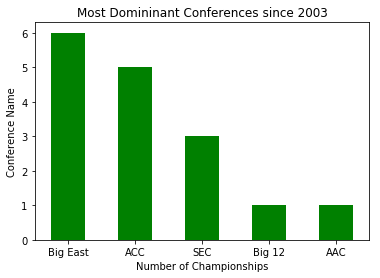

In [12]:
ModelHot[ModelHot['DayNum'] == 154]['W_Conf'].value_counts().plot(kind='bar',color='green')
plt.xlabel('Number of Championships')
plt.ylabel('Conference Name')
plt.xticks(np.arange(5),('Big East','ACC','SEC','Big 12', 'AAC'),rotation=0)
plt.title('Most Domininant Conferences since 2003')

The below looks at the teams with the most championships since 2003. Similar to the insights above, we can see that Connecticut and North Carolina are tied for the most success in that timespan, with Florida, Duke, and Villanova all tied for second.

Text(0.5, 1.0, 'Teams with the most championships since 2003')

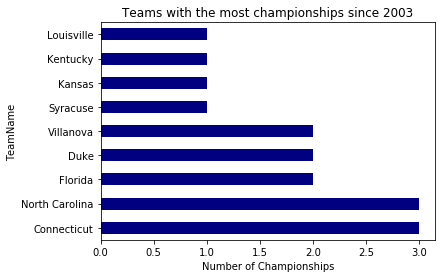

In [14]:
ModelHot[ModelHot['DayNum'] == 154]['W_TeamName'].value_counts().plot(kind='barh',color='navy')
plt.xlabel('Number of Championships')
plt.ylabel('TeamName')
plt.title('Teams with the most championships since 2003')

# Building the Model

To build the machine learning model, I had to meet two requirements. 
- The data must be formatted to include on numeric data
- The numeric data must account for two teams matching up against each other

This posed a problem:
- The data is formatted to always indicate winning teams and losing teams
- Adding a "Winners" column would then only show the results for all the games a team won, but not the ones it lost

Since I had already one hot encoded the region and seed data, the issue of accounting for categorical data was already resolved. In order to account for the results of both winning and losing teams, I decided to break the dataframe into two new dataframes: a dataset for all the games won by team and a dataset for all the games lost by a team. 

Every game won by a team would be classified with a 1, every game lost by a team would be classified with a 2. This gives the model the ability to differentiate the results of a won game versus a lost game. 

Post-classification, I appended the dataframes together to build my 2 class model. This involved finding the difference between the values of class 1 and class 2. Intuitively, you can think of it as the differential in score across a variety of metrics, with the classes being the outcome recorded by the model. The model would then be informed by the different combinations of differences in order to determine the probability of a team winning given a specific matchup.

In [34]:
#Make a model with both season stats and game information from 2003 - 2017
ModelDF = ModelHot[['Season','Tournament',
                    'WTeamID','W_TeamName','W_SeedNum','W_Region_DNC', 'W_Region_W','W_Region_X', 'W_Region_Y', 'W_Region_Z',
                    'LTeamID','L_TeamName','L_SeedNum','L_Region_DNC', 'L_Region_W','L_Region_X', 'L_Region_Y', 'L_Region_Z']]

ModelDF.rename(columns={'WTeamID':'1TeamID', 'W_TeamName':'1TeamName', 'W_SeedNum':'1SeedNum',
                        'W_Region_DNC':'1_Region_DNC', 'W_Region_W':'1_Region_W', 'W_Region_X':'1_Region_X', 
                        'W_Region_Y':'1_Region_Y', 'W_Region_Z':'1_Region_Z',
                       'LTeamID':'2TeamID', 'L_TeamName':'2TeamName', 'L_SeedNum':'2SeedNum',
                        'L_Region_DNC':'2_Region_DNC', 'L_Region_W':'2_Region_W', 'L_Region_X':'2_Region_X', 
                        'L_Region_Y':'2_Region_Y', 'L_Region_Z':'2_Region_Z'}, inplace=True)
#Currently the dataset is based upon winning teams being on the left 
#and losers on the right
#we want to account for both teams wins and losses, thus we need to make 2 ModelDF's

#Assign winner to our winners dataset
ModelDF['Winner'] = 1

#We want to have all the games played by a team in the teamname1 column, not just wins
ModelDF2 = ModelDF.copy()
ModelDF2 = ModelDF2[['Season', 'Tournament','2TeamID', '2TeamName', '2SeedNum', '2_Region_DNC', '2_Region_W',
       '2_Region_X', '2_Region_Y', '2_Region_Z', '1TeamID', '1TeamName', '1SeedNum',
       '1_Region_DNC', '1_Region_W', '1_Region_X', '1_Region_Y', '1_Region_Z']]

#Change the name of the inverted rows
ModelDF2.rename(columns = {'2TeamID':'1TeamID', '2TeamName':'1TeamName', '2SeedNum':'1SeedNum',
                           '2_Region_DNC':'1_Region_DNC', '2_Region_W':'1_Region_W',
                           '2_Region_X':'1_Region_X', '2_Region_Y':'1_Region_Y', '2_Region_Z':'1_Region_Z', 
                           '1TeamID':'2TeamID', '1TeamName':'2TeamName', '1SeedNum':'2SeedNum',
                           '1_Region_DNC':'2_Region_DNC', '1_Region_W':'2_Region_W', 
                           '1_Region_X':'2_Region_X', '1_Region_Y':'2_Region_Y', 
                           '1_Region_Z':'2_Region_Z'},inplace=True)
#Assign winner to our losers dataset
ModelDF2['Winner'] = 2


ModelTrain = pd.concat([ModelDF,ModelDF2])

In [35]:
#View the training model looking by ordering by every game each team played each season
ModelTrain = ModelTrain.sort_values(by=['Season','1TeamID'])

#Add the stats to the model
ModelTrain = pd.merge(ModelTrain,SeasonStats, how = 'left',left_on = ['Season','1TeamID','1TeamName'], 
         right_on = ['Season','TeamID','TeamName'])

#drop dupes
ModelTrain.drop(['TeamID','TeamName','Description'],axis = 1,inplace=True)

#Assign average season stats to each team in the dataset
rename_list = ['WOL','RTH','SAG','MOR','NumWins', 'NumLoss', 
                  'WinPct', 'Score', 'PointDiff', 'FGM','FGA', 'FGM3', 'FGA3', 'FTM', 
                  'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl','Blk', 'PF', 'Poss', '_OffRtg', 
                  '_DefRtg','_NetRtg', '_EFG', '_TS', 'IE','_OR_pct', '_DR_pct', '_REB_pct', 
                  '_TO_poss', '_FT_rate', '_AST_rtio','_BLK_pct', '_STL_pct']

#Rename columns for Team 1
for i in rename_list:
    ModelTrain.rename(columns = {f'{i}':f'1{i}'},inplace=True)
    
#redo for Team 2
ModelTrain = pd.merge(ModelTrain,SeasonStats, how = 'left',left_on = ['Season','2TeamID','2TeamName'], 
            right_on = ['Season','TeamID','TeamName'])
ModelTrain.drop(['TeamID','TeamName','Description'],axis = 1,inplace=True)

#Rename columns for Team 2
for i in rename_list:
    ModelTrain.rename(columns = {f'{i}':f'2{i}'},inplace=True)
    
#Reorder the columns to have team1 on left and team2 on right, with winner being last column
ModelTrain = ModelTrain[['Season', 'Tournament', '1TeamID', '1TeamName', '1SeedNum',
       '1_Region_DNC', '1_Region_W', '1_Region_X', '1_Region_Y', '1_Region_Z',
        '1WOL', '1RTH', '1SAG', '1MOR', '1NumWins', '1NumLoss', '1WinPct', '1Score',
        '1PointDiff', '1FGM', '1FGA', '1FGM3', '1FGA3', '1FTM', '1FTA', '1OR',
        '1DR', '1Ast', '1TO', '1Stl', '1Blk', '1PF', '1Poss', '1_OffRtg',
       '1_DefRtg', '1_NetRtg', '1_EFG', '1_TS', '1IE', '1_OR_pct', '1_DR_pct',
       '1_REB_pct', '1_TO_poss', '1_FT_rate', '1_AST_rtio', '1_BLK_pct','1_STL_pct',
       '2TeamID', '2TeamName', '2SeedNum', '2_Region_DNC', '2_Region_W',
       '2_Region_X', '2_Region_Y', '2_Region_Z', '2WOL', '2RTH', '2SAG', '2MOR', '2NumWins', '2NumLoss',
       '2WinPct', '2Score', '2PointDiff', '2FGM', '2FGA', '2FGM3', '2FGA3',
       '2FTM', '2FTA', '2OR', '2DR', '2Ast', '2TO', '2Stl', '2Blk', '2PF',
       '2Poss', '2_OffRtg', '2_DefRtg', '2_NetRtg', '2_EFG', '2_TS', '2IE',
       '2_OR_pct', '2_DR_pct', '2_REB_pct', '2_TO_poss', '2_FT_rate',
       '2_AST_rtio', '2_BLK_pct', '2_STL_pct','Winner']]

#Remove every null avg stat row
ModelTrain.drop(ModelTrain[ModelTrain['1WOL'].isnull()==True].index,inplace=True)
ModelTrain.drop(ModelTrain[ModelTrain['2NumLoss'].isnull()==True].index,inplace=True)
ModelTrain.drop(ModelTrain[ModelTrain['1IE'].isnull()==True].index,inplace=True)
ModelTrain.drop(ModelTrain[ModelTrain['2IE'].isnull()==True].index,inplace=True)


In [41]:
Stats1 = ['1SeedNum',
       '1_Region_DNC', '1_Region_W', '1_Region_X', '1_Region_Y', '1_Region_Z',
       '1WOL', '1RTH', '1SAG', '1MOR', '1NumWins', '1NumLoss', '1WinPct',
       '1Score', '1PointDiff', '1FGM', '1FGA', '1FGM3', '1FGA3', '1FTM',
       '1FTA', '1OR', '1DR', '1Ast', '1TO', '1Stl', '1Blk', '1PF', '1Poss',
       '1_OffRtg', '1_DefRtg', '1_NetRtg', '1_EFG', '1_TS', '1IE', '1_OR_pct',
       '1_DR_pct', '1_REB_pct', '1_TO_poss', '1_FT_rate', '1_AST_rtio',
       '1_BLK_pct', '1_STL_pct']
Stats2 = ['2SeedNum',
       '2_Region_DNC', '2_Region_W', '2_Region_X', '2_Region_Y', '2_Region_Z',
       '2WOL', '2RTH', '2SAG', '2MOR', '2NumWins', '2NumLoss', '2WinPct',
       '2Score', '2PointDiff', '2FGM', '2FGA', '2FGM3', '2FGA3', '2FTM',
       '2FTA', '2OR', '2DR', '2Ast', '2TO', '2Stl', '2Blk', '2PF', '2Poss',
       '2_OffRtg', '2_DefRtg', '2_NetRtg', '2_EFG', '2_TS', '2IE', '2_OR_pct',
       '2_DR_pct', '2_REB_pct', '2_TO_poss', '2_FT_rate', '2_AST_rtio',
       '2_BLK_pct', '2_STL_pct']
ColumnName = ['SeedNum',
       'Region_DNC', 'Region_W', 'Region_X', 'Region_Y', 'Region_Z',
       'WOL', 'RTH', 'SAG', 'MOR', 'NumWins', 'NumLoss', 'WinPct',
       'Score', 'PointDiff', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM',
       'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'Poss',
       '_OffRtg', '_DefRtg', '_NetRtg', '_EFG', '_TS', 'IE', '_OR_pct',
       '_DR_pct', '_REB_pct', '_TO_poss', '_FT_rate', '_AST_rtio',
       '_BLK_pct', '_STL_pct']

#To reduce the amount of data the model has to train and reduce training time, we will train on 10 years of data
#Train from years 2008-2017, validate on 2018
ModelTrain2017 = ModelTrain[(ModelTrain['Season'] < 2018) & (ModelTrain['Season'] > 2007)]
ModelVal2018 = ModelTrain[(ModelTrain['Season'] > 2017)]

#Create new dataframe and loop for new columns
#New dataframe will look for the difference in values between teams 1 and 2
#difference and values necessary for fitting the data to the classification model
ModelDiff2017 = pd.DataFrame()

for stat_1,stat_2,Col in zip(Stats1,Stats2,ColumnName):
    ModelDiff2017[Col] = ModelTrain2017[stat_1] - ModelTrain2017[stat_2]
    ModelDiff2017['Winner'] = ModelTrain2017['Winner']

ModelDiff2017 = ModelDiff2017[['SeedNum', 'Region_DNC', 'Region_W', 'Region_X', 'Region_Y',
       'Region_Z', 'WOL', 'RTH', 'SAG', 'MOR', 'NumWins', 'NumLoss', 'WinPct',
       'Score', 'PointDiff', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR',
       'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'Poss', '_OffRtg', '_DefRtg',
       '_NetRtg', '_EFG', '_TS', 'IE', '_OR_pct', '_DR_pct', '_REB_pct',
       '_TO_poss', '_FT_rate', '_AST_rtio', '_BLK_pct', '_STL_pct','Winner']]

#Create new dataframe and loop for new columns
ModelDiff2018 = pd.DataFrame()

for stat_1,stat_2,Col in zip(Stats1,Stats2,ColumnName):
    ModelDiff2018[Col] = ModelVal2018[stat_1] - ModelVal2018[stat_2]
    ModelDiff2018['Winner'] = ModelVal2018['Winner']

ModelDiff2018 = ModelDiff2018[['SeedNum', 'Region_DNC', 'Region_W', 'Region_X', 'Region_Y',
       'Region_Z', 'WOL', 'RTH', 'SAG', 'MOR', 'NumWins', 'NumLoss', 'WinPct',
       'Score', 'PointDiff', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR',
       'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'Poss', '_OffRtg', '_DefRtg',
       '_NetRtg', '_EFG', '_TS', 'IE', '_OR_pct', '_DR_pct', '_REB_pct',
       '_TO_poss', '_FT_rate', '_AST_rtio', '_BLK_pct', '_STL_pct','Winner']]


In [ ]:
ModelDiff2017.drop(ModelDiff2017[ModelDiff2017['WOL'].isnull()==True].index,inplace=True)

In [44]:
#Test both models for null values
print(ModelDiff2017.isna().sum().sort_values(ascending=False).head())
print(ModelDiff2018.isna().sum().sort_values(ascending=False).head())
print(ModelDiff2017.shape)
print(ModelDiff2018.shape)

Winner      0
_STL_pct    0
FTM         0
FGA3        0
FGM3        0
dtype: int64
Winner      0
_STL_pct    0
FTM         0
FGA3        0
FGM3        0
dtype: int64
(86934, 44)
(9190, 44)


In [46]:
#What is the proportion of 1s and 2s in the datasets?
print(ModelDiff2017[ModelDiff2017['Winner']==1]['Winner'].count())
print(43467/86934)
print(ModelDiff2018[ModelDiff2018['Winner']==1]['Winner'].count())
print(4595/9190)
#perfect balance between the winners of 1 and 2

43467
0.5
4595
0.5


In [39]:
ModelDiff2017.to_csv('NCAA_TrainingSet.csv',encoding = 'utf-8', index = False)
ModelDiff2018.to_csv('NCAA_ValidationSet.csv',encoding = 'utf-8', index = False)

In [41]:
ModelDiff2017

,SeedNum,Region_DNC,Region_W,Region_X,Region_Y,Region_Z,WOL,RTH,SAG,MOR,NumWins,NumLoss,WinPct,Score,PointDiff,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Poss,_OffRtg,_DefRtg,_NetRtg,_EFG,_TS,IE,_OR_pct,_DR_pct,_REB_pct,_TO_poss,_FT_rate,_AST_rtio,_BLK_pct,_STL_pct,Winner
0,0,0,0,0,0,0,-108.0,-134.0,-139.0,-165.0,5.0,-4.0,0.166667,-11.231481,3.703704,-5.144180,-10.072751,2.832011,4.654762,-3.775132,-5.054233,-3.402116,-0.899471,1.067460,-0.914021,-1.074074,-0.859788,-0.861111,-9.586000,-2.363599,-8.127401,5.763802,0.032302,0.019681,5.413401e+00,-0.057792,0.080418,0.011313,0.020538,-0.012212,3.326941,-0.005714,-0.000925,1
1,0,0,0,0,0,0,-75.0,-93.0,-85.0,-123.0,3.0,-2.0,0.092593,-11.837542,1.734007,-4.501082,-7.931337,0.094637,-0.331770,-2.930014,-3.242785,-1.701780,-0.417989,-0.642977,-3.718735,-1.454545,-0.395142,-2.224747,-11.029071,-0.892232,-3.595076,2.702843,-0.003690,-0.008229,3.198636e-02,-0.032162,0.051681,0.009759,-0.014446,-0.015348,1.566698,-0.002701,-0.001233,1
2,0,0,0,0,0,0,-110.0,-136.0,-142.0,-180.0,6.0,-6.0,0.214286,-21.357143,2.785714,-6.910714,-16.875000,-1.178571,-6.053571,-6.357143,-9.535714,-4.839286,-2.946429,-3.571429,-0.857143,-1.517857,-1.107143,-4.964286,-16.725429,-5.535167,-9.836079,4.300912,0.019024,0.010238,-1.681641e+01,-0.050390,0.085616,0.017613,0.042215,-0.033901,0.274216,-0.008083,0.005134,1
3,2,1,0,0,0,255,-100.0,-143.0,-145.0,-172.0,-1.0,-1.0,0.000000,-7.583333,0.000000,-3.640476,-8.635714,2.802381,5.921429,-3.104762,-5.169048,-4.842857,-1.247619,1.111905,-1.454762,-0.466667,-1.119048,-0.816667,-7.394800,-0.327409,-0.266649,-0.060760,0.047791,0.037224,-7.105427e-15,-0.104952,0.104952,0.000000,0.005132,-0.013149,3.217173,-0.014012,0.005252,1
4,0,0,0,0,0,0,-152.0,-173.0,-177.0,-204.0,7.0,-8.0,0.258621,-14.503695,4.064039,-5.511084,-12.557882,3.333744,6.745074,-6.815271,-12.466749,-7.635468,-2.241379,1.341133,-2.346059,-0.073892,-1.445813,-3.557882,-12.662571,-2.995073,-9.136089,6.141016,0.049224,0.038193,-4.798017e+00,-0.123224,0.062750,-0.030237,0.009873,-0.052132,4.696691,-0.016204,0.019747,1
5,0,0,0,0,0,0,-65.0,-128.0,-124.0,-181.0,-2.0,-1.0,-0.016129,-12.943548,-0.262097,-6.209965,-12.763537,1.894585,2.831509,-2.418203,-3.858295,-4.743664,-1.847350,0.464862,-2.494816,-1.701613,-1.154666,-1.372984,-11.853484,-1.362300,-1.043692,-0.318609,0.025866,0.022574,-2.515713e-01,-0.088160,0.087021,-0.000570,0.006509,0.023729,3.217809,-0.008610,-0.005682,1
6,10,1,0,255,0,0,144.0,119.0,114.0,68.0,-11.0,7.0,-0.281250,-13.550000,-7.200000,-5.625893,-11.846964,0.008214,-2.019821,-2.306429,-1.976964,-2.920357,-3.673036,-2.566429,2.343571,-0.928750,-0.960714,1.112500,-7.221210,-9.965403,1.143160,-11.108562,0.012279,0.004529,-4.078421e+00,-0.041684,0.054401,0.006358,0.064022,0.020413,-0.449085,-0.008571,-0.001920,1
7,0,0,0,0,0,0,-38.0,-27.0,-33.0,-33.0,4.0,-4.0,0.142857,-8.592857,3.314286,-4.078571,-14.435714,2.185714,1.142857,-2.621429,-2.492857,-3.921429,-3.921429,-0.035714,-1.178571,-0.428571,-2.535714,-1.300000,-12.361886,5.488149,0.608165,4.879985,0.072280,0.056693,-7.851614e+00,-0.029026,0.029237,0.000106,0.026420,0.013856,2.720159,-0.035535,0.013153,1
8,0,0,0,0,0,0,-118.0,-118.0,-103.0,-107.0,8.0,-10.0,0.300000,-1.316667,6.700000,-2.473810,-10.135714,1.869048,-0.078571,1.761905,1.497619,-2.509524,0.552381,2.345238,1.111905,1.733333,-0.652381,-0.150000,-5.570800,6.562190,-3.621914,10.184104,0.070530,0.072994,-5.834440e+00,-0.024010,0.022355,-0.000827,0.040842,0.082571,3.794096,-0.009820,0.036155,1
9,0,0,0,0,0,0,-14.0,-12.0,-21.0,-24.0,1.0,-2.0,0.051724,-12.811008,1.416446,-5.839238,-12.041019,1.113964,0.902330,-2.246495,-4.323513,-3.455854,-4.051156,-2.407635,-2.992516,-1.456233,-0.597385,-1.760610,-13.086095,-0.025230,-1.970720,1.945490,0.020798,0.018787,7.171481e+00,-0.046951,0.053775,0.003412,0.002798,0.019226,0.773607,-0.000223,-0.000445,1


# Train the Model

In the previous code, we had separated the Season stat differential dataset into 2017 and 2018. ModelDiff2017 is our training set where we will train the data on the differential stats for all games from 2008 to 2017. We validate our model against the results of the 2018 tournament.

In [40]:
ModelDiff2017 = pd.read_csv('NCAA_TrainingSet.csv')
ModelDiff2018 = pd.read_csv('NCAA_ValidationSet.csv')

In [43]:
from sklearn.model_selection import train_test_split

X = ModelDiff2017.iloc[:,:-1]
y = ModelDiff2017['Winner']

In [36]:
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size = 0.8,random_state = 64)

## Feature Selection

Before training the model using various classifiers, I used a variance threshold analysis to identify the features that are most relevant to the model. This is a form of feature engineering that finds the features with the most variance, or in other words, the features that provide the most information to the model.

In [44]:
## Feature Selection code
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0)
Xfixed = sel.fit_transform(X)

X_labels = ['SeedNum', 'Region_DNC', 'Region_W', 'Region_X', 'Region_Y',
       'Region_Z', 'WOL', 'RTH', 'SAG', 'MOR', 'NumWins', 'NumLoss', 'WinPct',
       'Score', 'PointDiff', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR',
       'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'Poss', '_OffRtg', '_DefRtg',
       '_NetRtg', '_EFG', '_TS', 'IE', '_OR_pct', '_DR_pct', '_REB_pct',
       '_TO_poss', '_FT_rate', '_AST_rtio', '_BLK_pct', '_STL_pct']

variance_list = sel.variances_
var_dict = dict(zip(X_labels,variance_list))
var_dict

{'SeedNum': 27.337727471415096,
 'Region_DNC': 7619.420160824507,
 'Region_W': 2694.6357165622694,
 'Region_X': 2734.8825113304138,
 'Region_Y': 2853.9034943683055,
 'Region_Z': 2795.479555339487,
 'WOL': 13765.219729910046,
 'RTH': 11758.594220903215,
 'SAG': 12489.927531230589,
 'MOR': 11706.052706651022,
 'NumWins': 69.66731083350588,
 'NumLoss': 54.15308164814687,
 'WinPct': 0.06466287636140115,
 'Score': 53.52710468293649,
 'PointDiff': 36.40750357527576,
 'FGM': 7.8881093023942155,
 'FGA': 20.637188831033594,
 'FGM3': 2.2207539948542867,
 'FGA3': 11.082243576706169,
 'FTM': 7.382583105401426,
 'FTA': 13.130038450820205,
 'OR': 3.7100861281365036,
 'DR': 5.386201235049139,
 'Ast': 5.531190490923513,
 'TO': 4.213066885530589,
 'Stl': 1.896870692003662,
 'Blk': 1.2966194379876061,
 'PF': 5.259495153783682,
 'Poss': 18.853961044972447,
 '_OffRtg': 67.36312994726221,
 '_DefRtg': 50.61262321904565,
 '_NetRtg': 86.95141856209858,
 '_EFG': 0.0016864263818195478,
 '_TS': 0.001516534482653

In [57]:
var_keys = list(var_dict.keys())
var_values = list(var_dict.values())

Overall, we see that the ratings systems and regions have the most variance in the model. Of the statistical categories, features like Net Rating, SeedNum, Wins, Losses, and Point Differential are also important features that high variance.

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

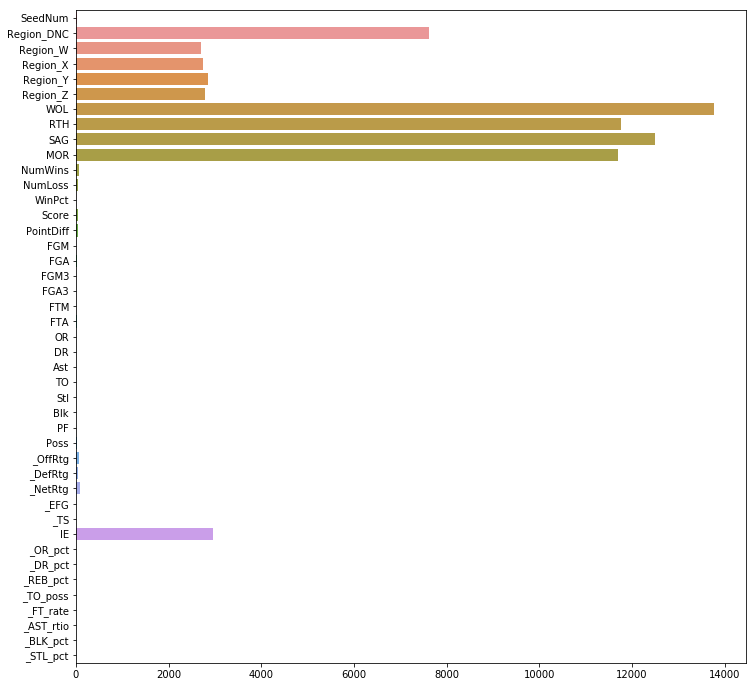

In [78]:
plt.figure(figsize=(12,12))
sns.barplot(y=var_keys,x=var_values,orient="h")

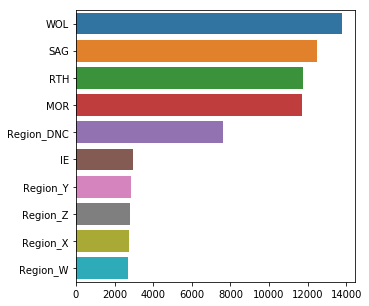

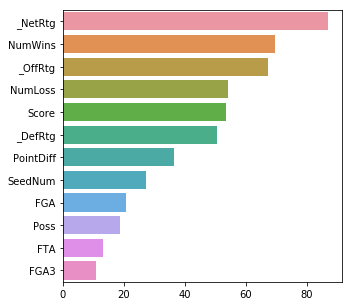

In [91]:
plt.figure(figsize=(5,5))
sns.barplot(y=var_keys,x=var_values,orient="h", order=['WOL','SAG','RTH','MOR','Region_DNC','IE',
                                                       'Region_Y','Region_Z','Region_X','Region_W'])
plt.figure(figsize=(5,5))
sns.barplot(y=var_keys,x=var_values,orient="h", order=['_NetRtg','NumWins','_OffRtg','NumLoss','Score',
                                                       '_DefRtg','PointDiff','SeedNum','FGA','Poss','FTA','FGA3'])

To account for potential multi-collinearity in the model from the various columns, I used a KBest analysis to score and identify the best features, while also analysing each features significance through its p-values. All 30 categories selected were statistically significant with p-values below 0.05. One interesting revelation is the absence of the one hot encoded region columns; only the DNC region column is present.

In [47]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#Select the Kbest features in the model
selector = SelectKBest(f_regression, k=30)
X_new = selector.fit(X,y)
selector.get_support(indices=True)
Xcols = X_new.get_support(indices = True)

print(Xcols)
print(ModelDiff2017.columns[Xcols])

print(X_new.scores_)
print(X_new.pvalues_)

[ 0  1  6  7  8  9 10 11 12 13 14 15 17 19 22 23 24 26 27 29 30 31 32 33
 35 37 38 39 40 41]
Index(['SeedNum', 'Region_DNC', 'WOL', 'RTH', 'SAG', 'MOR', 'NumWins',
       'NumLoss', 'WinPct', 'Score', 'PointDiff', 'FGM', 'FGM3', 'FTM', 'DR',
       'Ast', 'TO', 'Blk', 'PF', '_OffRtg', '_DefRtg', '_NetRtg', '_EFG',
       '_TS', '_OR_pct', '_REB_pct', '_TO_poss', '_FT_rate', '_AST_rtio',
       '_BLK_pct'],
      dtype='object')
[1.15445716e+04 5.81882730e+03 9.47696629e+02 9.65588449e+02
 8.65132073e+02 1.01812275e+03 4.36049299e+04 4.28064781e+04
 4.15695276e+04 3.78372124e+04 3.79341525e+04 3.37789280e+04
 3.70587235e+04 5.38972420e+03 3.20723568e+04 4.33239141e+03
 4.75721664e-01 1.20339242e+03 2.51767104e+02 1.64026172e+03
 5.87751654e+02 6.24582268e+01 4.10187884e+03 5.29489808e+03
 2.26784490e+03 4.56392852e+02 3.33132208e+03 4.54407711e+03
 8.97431816e+01 1.29750516e+04 6.50267295e+03 3.19591363e+04
 8.75941837e+03 9.88043050e+03 1.83188659e+01 1.31710622e+03
 3.68881506e+02 4.1

Analyzing a heatmap of the features, we can see that percentages are highly correlated to their non-percentage counterparts. In contrast to the results of our feature selection, the ratings systems all being highly correlated with each other, a potential sign of multicollinearity. I was unwilling to remove the ratings columns because I felt that each ratings system had predictive power and I also wanted the model to consider the group consensus of the ratings systems when making predictions. Thus, I decided to use PCA analysis for feature engineering instead of removing the highly correlated columns. PCA reduces dimensionality to capture the maximum amount of variance in the system. This means that the ratings will blend together as they share the same amount of variance, removing the need to take the columns out of the model. 

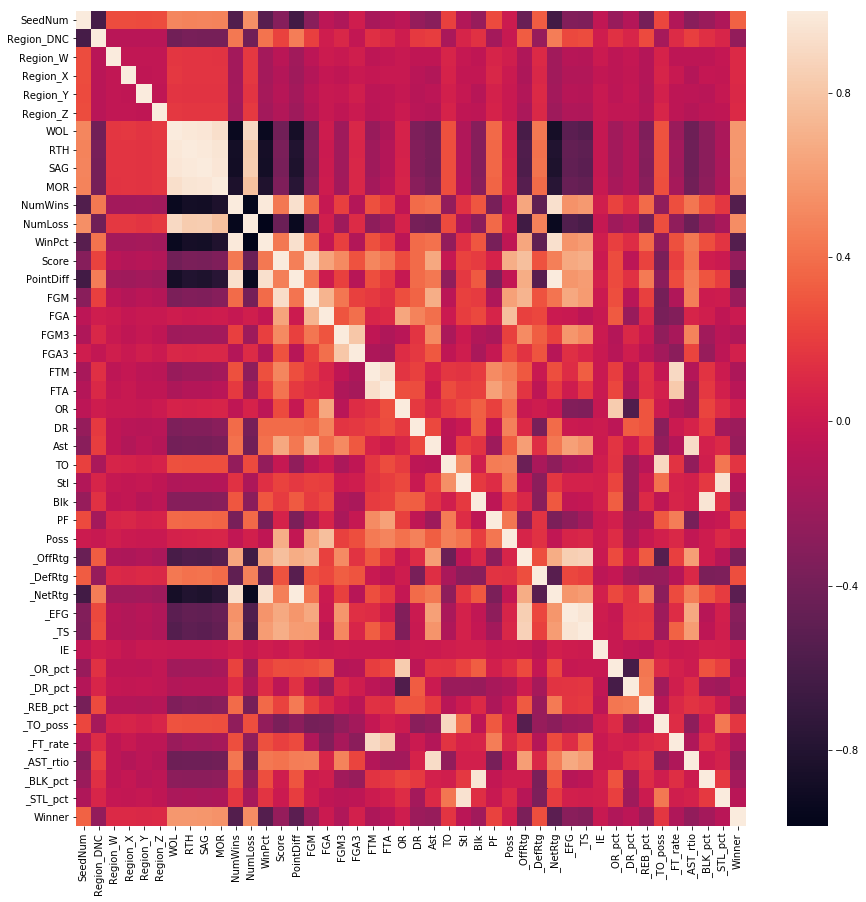

In [42]:
corr = ModelDiff2017.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr)

## Supervised Learning Methods

With model set up in a way to address a classification problem, I used 5 classifiers to help make predictions:
- logistic regression
- decision trees
- random forest
- bagging (using logistic regression)
- XGBoost

I chose a range of classifiers to see if different classification methods were more accurate in predicting the outcome of the tournament. These classifiers would be tested with various transformers through a grid search pipeline method to unlock its optimal parameters. This allows us to test combinations of parameters that give us the best results on a variety of metrics. For the purpose of this project, I wanted to look at accuracy, precision, and recall score. I chose GridSearchCV for its ability to exhaustively evaluate all hyperparameter combinations, and also its ability to cross validate across various sets of the the training data.

Random Forest and XGBoost proved to be the most computationally intensive of the various models because my computer either ran for extended periods of time or the kernel would die. I utilized AWS Sagemaker m4.xlarge to help with the calculations.

Furthermore, I had intended to also use a support vector classifier on my model, however, it proved to be too computationally intense, even when run with AWS Sagemaker.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection

from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import pipeline
from sklearn.externals import joblib

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#### Logistic Regression

In [ ]:
scaler = StandardScaler()
logit = linear_model.LogisticRegression()
pca = PCA()


estimators = [('scaler',scaler),
             ('pca',pca),
             ('logit',logit)]

pipe = pipeline.Pipeline(estimators)

params = {'logit__C':[0.001,0.01,0.1,1,10,100,1000], 'logit__solver':['lbfgs','sag'],
          'logit__class_weight':['balanced', None],
         'pca__n_components':[10,15,20,25,30,35,40]}

grid_search = GridSearchCV(pipe, param_grid=params)

X_train,X_val,y_train,y_val = train_test_split(X,y,train_size = 0.8,random_state = 64)
    
fitted_search = grid_search.fit(X_train, y_train)

In [ ]:
joblib.dump(fitted_search,'fitted_search.pkl')

In [37]:
fitted_search.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logit', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False))])

In [38]:
print('Train Score:',fitted_search.score(X_train,y_train))
print('Validation Score:',fitted_search.score(X_val,y_val))

Train Score: 0.751851266050297
Validation Score: 0.7541266463449704


#### Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [ ]:
estimators = [('scaler',scaler),
             ('pca',pca),
             ('dt',dt)]

pipe = pipeline.Pipeline(estimators)

params = {'dt__max_depth':[1,5,10,15,20,25,30,35,40],
         'pca__n_components':[5,10,15,20,25,30]}

grid_search = GridSearchCV(pipe, param_grid=params)

X_train,X_val,y_train,y_val = train_test_split(X,y,train_size = 0.8,random_state = 64)
    
fitted_search_dt = grid_search.fit(X_train, y_train)

In [ ]:
joblib.dump(fitted_search_dt,'fitted_search_dt.pkl')

In [23]:
fitted_search_dt.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [24]:
print('Train Score:',fitted_search_dt.score(X_train,y_train))
print('Validation Score:',fitted_search_dt.score(X_val,y_val))

Train Score: 0.5645678462047249
Validation Score: 0.5692758957842066


#### Random Forest

In [ ]:
#Random Forest
estimators = [('scaler',scaler),
             ('pca',pca),
             ('rf',rf)]

pipe = pipeline.Pipeline(estimators)

params = {'rf__n_estimators':[1,5,10,20,30,40,50,60,70,80,90,100],
         'pca__n_components':[15,20,25,30,35,40]}

grid_search = GridSearchCV(pipe, param_grid=params)

X_train,X_val,y_train,y_val = train_test_split(X,y,train_size = 0.8,random_state = 64)
    
fitted_search_rf = grid_search.fit(X_train, y_train)

In [ ]:
joblib.dump(fitted_search_rf,'fitted_search_rf.pkl')

In [26]:
fitted_search_rf.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [25]:
print('Train Score:',fitted_search_rf.score(X_train,y_train))
print('Validation Score:',fitted_search_rf.score(X_val,y_val))

Train Score: 0.678231987001596
Validation Score: 0.6359348938862368


#### Bagging - Logistic Regression

In [ ]:
bag = BaggingClassifier(logit)

estimators = [('scaler',scaler),
             ('pca',pca),
             ('bag',bag)]

pipe = pipeline.Pipeline(estimators)

params = {'bag__n_estimators':[1,5,10,20,30,40,50,60,70,80,90,100],
         'pca__n_components':[15,20,25,30,35,40]}

grid_search = GridSearchCV(pipe, param_grid=params)

X_train,X_val,y_train,y_val = train_test_split(X,y,train_size = 0.8,random_state = 64)
    
fitted_search_bag = grid_search.fit(X_train, y_train)

In [ ]:
joblib.dump(fitted_search_bag,'fitted_search_bag.pkl')

In [27]:
fitted_search_bag.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('bag', BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=Fals...imators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])

In [28]:
print('Train Score:',fitted_search_bag.score(X_train,y_train))
print('Validation Score:',fitted_search_bag.score(X_val,y_val))

Train Score: 0.7518944023466145
Validation Score: 0.7540691321101973


#### Boosting - XGBoost

In [6]:
!conda install -y -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.6.8

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    libxgboost-0.82            |       he1b5a44_0         3.9 MB  conda-forge
    xgboost-0.82               |   py36he1b5a44_0           9 KB  conda-forge
    py-xgboost-0.82            |   py36he1b5a44_0          70 KB  conda-forge
    ------------------------------------------------------------
                                           Total:       

In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost 
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
#XGBoost
xgb = XGBClassifier()

estimators = [('scaler',scaler),
             ('pca',pca),
             ('xgb',xgb)]

pipe = pipeline.Pipeline(estimators)

params = {'xgb__booster':['gbtree'],
          'xgb__max_depth':[1,5,10,15,20,25,30],
         'pca__n_components':[20,25,30]}

grid_search = GridSearchCV(pipe, param_grid=params,cv=5)

X_train,X_val,y_train,y_val = train_test_split(X,y,train_size = 0.8,random_state = 64)
    
fitted_search_xgb = grid_search.fit(X_train, y_train)

In [ ]:
joblib.dump(fitted_search_xgb,'fitted_search_xgb.pkl')

In [29]:
fitted_search_xgb.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_b...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [30]:
print('Train Score:',fitted_search_xgb.score(X_train,y_train))
print('Validation Score:',fitted_search_xgb.score(X_val,y_val))

Train Score: 0.5844968151034552
Validation Score: 0.5868752516247772


# Validating Against 2018 Data

In [8]:
ModelDiff2018 = pd.read_csv('ModelDiff2018.csv')
X_test = ModelDiff2018.iloc[:,:-1]
y_test = ModelDiff2018['Winner']

In [15]:
fitted_search_bag = joblib.load('fitted_search_bag.pkl')
fitted_search_dt = joblib.load('fitted_search_dt.pkl')
fitted_search_rf = joblib.load('fitted_search_rf.pkl')
fitted_search_xgb = joblib.load('fitted_search_xgb.pkl')
fitted_search = joblib.load('fitted_search.pkl')

In [9]:
# load all the models from disk
bag_model = joblib.load('fitted_search_bag.pkl')
dt_model = joblib.load('fitted_search_dt.pkl')
rf_model = joblib.load('fitted_search_rf.pkl')
xgb_model = joblib.load('fitted_search_xgb.pkl')
logit_model = joblib.load('fitted_search.pkl')

In [10]:
y_pred_bag = bag_model.predict(X_test)
y_true = y_test
accuracy_bag = accuracy_score(y_true, y_pred_bag)
recall_bag = recall_score(y_true,y_pred_bag)
precision_bag = precision_score(y_true,y_pred_bag)
print('Bagging Accuracy:',accuracy_bag)
print('Bagging Recall:',recall_bag)
print('Bagging Precision:',precision_bag,'\n')

y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_true, y_pred_dt)
recall_dt = recall_score(y_true,y_pred_dt)
precision_dt = precision_score(y_true,y_pred_dt)
print('Decision Tree Accuracy:',accuracy_dt)
print('Decision Tree Recall:',recall_dt)
print('Decision Tree Precision:',precision_dt,'\n')

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_true, y_pred_rf)
recall_rf = recall_score(y_true,y_pred_rf)
precision_rf = precision_score(y_true,y_pred_rf)
print('Random Forest Accuracy:',accuracy_rf)
print('Random Forest Recall:',recall_rf)
print('Random Forest Precision:',precision_rf,'\n')

y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_true, y_pred_xgb)
recall_xgb = recall_score(y_true,y_pred_xgb)
precision_xgb = precision_score(y_true,y_pred_xgb)
print('XGBoost Accuracy:',accuracy_xgb)
print('XGBoost Recall:',recall_xgb)
print('XGBoost Precision:',precision_xgb,'\n')

y_pred_log = logit_model.predict(X_test)
accuracy_log = accuracy_score(y_true, y_pred_log)
recall_log = recall_score(y_true,y_pred_log)
precision_log = precision_score(y_true,y_pred_log)
print('Logit Accuracy:',accuracy_log)
print('Logit Recall:',recall_log)
print('Logit Precision:',precision_log,'\n')

Bagging Accuracy: 0.7613710554951034
Bagging Recall: 0.761044613710555
Bagging Precision: 0.7615418118466899 

Decision Tree Accuracy: 0.7396082698585419
Decision Tree Recall: 0.7401523394994559
Decision Tree Precision: 0.7393478260869565 

Random Forest Accuracy: 0.7486398258977149
Random Forest Recall: 0.7503808487486399
Random Forest Precision: 0.747777054868792 

XGBoost Accuracy: 0.7540805223068553
XGBoost Recall: 0.7545157780195865
XGBoost Precision: 0.7538595346814525 

Logit Accuracy: 0.7623503808487486
Logit Recall: 0.7623503808487486
Logit Precision: 0.7623503808487486 



Validating the models on our validation set, the logistic regression was able to achieve the highest accuracy, recall, and precision score. Thus, we will make our predictions using the logit model.

# See Part II for the Predictions